<a href="https://colab.research.google.com/github/elhamshaerirahbar-bot/my-colab-project/blob/main/Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow

In [3]:
import numpy as np, pandas as pd, re, unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [17]:
import pandas as pd

# Just read the file
df = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print(df.head())

   Run  Factor A  Factor B  Factor C  Factor D  Response 1 (Experimental)  \
0    1       110         7        50        10                    1127.19   
1    2        85        13        50        10                    1024.97   
2    3       101         1       500        60                    1950.00   
3    4       101         1       500        60                    2223.17   
4    5        50        10        50        10                    1845.60   

   Response 2 (Experimental)  
0                    1321.65  
1                    1339.35  
2                    2878.90  
3                    2989.00  
4                    2690.50  


In [18]:
#select columns by position
X = df.iloc[:, 1:5].astype(float).to_numpy()  # First 4 columns as features
y = df.iloc[:, 5:7].astype(float).to_numpy()  # Next 2 columns as targets

print("X:", X.shape, " y:", y.shape)

X: (25, 4)  y: (25, 2)


In [19]:
# For 20% test, 16% val, 64% train:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, shuffle=True, random_state=SEED  # 0.20 of 0.80 = 0.16 overall
)

In [20]:
#scaling
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Ensure y has correct shape (samples, 2_targets)
assert y_train.ndim == 2 and y_train.shape[1] == 2, "y muss (n,2) sein"

# --- Scale features (X) using StandardScaler ---
# Fit scaler only on training data to prevent data leakage
x_scaler = StandardScaler().fit(X_train)

# Transform all sets using the same scaler (mean=0, std=1)
X_train_z = x_scaler.transform(X_train)  # Standardized training features
X_val_z   = x_scaler.transform(X_val)    # Standardized validation features  
X_test_z  = x_scaler.transform(X_test)   # Standardized test features

# --- Scale targets (y) to [-1,1] range for tanh activation ---
# Fit scaler only on training targets to prevent data leakage
y_scaler  = MinMaxScaler(feature_range=(-1, 1)).fit(y_train)  # y_train: (n,2)

# Transform all target sets using the same scaler
y_train_s = y_scaler.transform(y_train)  # Scaled training targets [-1,1]
y_val_s   = y_scaler.transform(y_val)    # Scaled validation targets [-1,1]
y_test_s  = y_scaler.transform(y_test)   # Scaled test targets [-1,1]

def inv_y(y_s):
    """
    Inverse transform scaled predictions back to original units.
    Args: y_s - scaled predictions in [-1,1] range
    Returns: predictions in original scale (Mn, Mw units)
    """
    return y_scaler.inverse_transform(y_s)

In [21]:
ann = tf.keras.models.Sequential()

In [23]:
#build ann
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Verify target shape (samples, 2_outputs)
assert y_train_s.ndim == 2 and y_train_s.shape[1] == 2, "y muss (n,2) sein!"

# Build Neural Network: 4 inputs -> 3 hidden layers (16,8,8) -> 2 outputs
# Architecture: fully connected feedforward network with regularization
# Purpose: predict 2 molecular weight responses (Mn, Mw) from 4 factors
model = Sequential([
    # Input layer: 4 features -> 16 neurons
    # ReLU activation for non-linearity
    # L2 regularization to prevent overfitting
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 input_shape=(X_train_z.shape[1],)),
    
    # Dropout to reduce overfitting (randomly disable 10% of neurons)
    Dropout(0.1),
    
    # Hidden layer: 16 -> 8 neurons
    layers.Dense(8, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
    
    # Hidden layer: 8 -> 8 neurons  
    layers.Dense(8, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
    
    # Output layer: 8 -> 2 outputs (Mn, Mw)
    # Tanh activation outputs [-1,1] to match our scaled targets
    layers.Dense(2, activation='tanh')
])

# Compile model
# MSE loss for regression, MAE and MAPE as additional metrics
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae', 'mape'])

In [24]:
#model training
from tensorflow.keras.callbacks import EarlyStopping

# Compile model with optimizer and loss function
model.compile(optimizer='adam',    # Adaptive learning rate optimizer
              loss='mse',          # Mean Squared Error for regression
              metrics=['mae', 'mape'])  # Track Mean Absolute Error and Mean Absolute Percentage Error

# Early stopping to prevent overfitting
# Stops training when validation loss doesn't improve for 25 epochs
# Restores the best weights found during training
early = EarlyStopping(monitor='val_loss',        # Watch validation loss
                     patience=25,                # Wait 25 epochs without improvement
                     restore_best_weights=True)  # Keep best model weights

# Train the model
# Uses scaled features (X_train_z) and scaled targets (y_train_s) in [-1,1] range
# Validates on separate validation set to monitor overfitting
history = model.fit(
    X_train_z, y_train_s,                    # Training data (scaled)
    validation_data=(X_val_z, y_val_s),     # Validation data (scaled)
    epochs=500,                              # Maximum 500 epochs
    batch_size=16,                           # Process 16 samples at a time
    verbose=1,                               # Print progress during training
    callbacks=[early]                        # Apply early stopping
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4955 - mae: 0.5618 - mape: 127.8901 - val_loss: 0.3090 - val_mae: 0.4277 - val_mape: 152.5448
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4625 - mae: 0.5620 - mape: 144.5456 - val_loss: 0.3059 - val_mae: 0.4250 - val_mape: 149.7119
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4403 - mae: 0.5414 - mape: 118.5616 - val_loss: 0.3029 - val_mae: 0.4223 - val_mape: 146.7029
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4583 - mae: 0.5439 - mape: 128.5281 - val_loss: 0.3000 - val_mae: 0.4195 - val_mape: 143.1570
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4455 - mae: 0.5269 - mape: 110.1732 - val_loss: 0.2973 - val_mae: 0.4167 - val_mape: 139.8304
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.4521 - mae: 0.5362 - mape: 108.6820 - val_loss: 0.2946 - val_mae: 0.4141 - val_mape: 136.7745
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4686 - mae: 0.5346

In [25]:
# Make predictions on all sets
y_hat_train_s = model.predict(X_train_z)
y_hat_val_s   = model.predict(X_val_z)
y_hat_test_s  = model.predict(X_test_z)

# Convert predictions back to original scale
y_hat_train = inv_y(y_hat_train_s)
y_hat_val   = inv_y(y_hat_val_s)
y_hat_test  = inv_y(y_hat_test_s)

# Print prediction shapes
print("Prediction shapes:")
print(f"Train: {y_hat_train.shape}")
print(f"Val:   {y_hat_val.shape}")
print(f"Test:  {y_hat_test.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction shapes:
Train: (16, 2)
Val:   (4, 2)
Test:  (5, 2)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def report_2out(name, y_true, y_pred, labels=("Mn", "Mw")):
    for i, label in enumerate(labels):
        # Extract single output column
        yt = y_true[:, i]
        yp = y_pred[:, i]
        
        # Calculate metrics
        mae  = mean_absolute_error(yt, yp)
        mse  = mean_squared_error(yt, yp)
        r2   = r2_score(yt, yp)
        mape = mean_absolute_percentage_error(yt, yp)
        
        # Print results
        print(f"[{name}] {label}: MAE={mae:.6f}  MSE={mse:.6f}  R²={r2:.4f}  MAPE={mape:.6f}")

In [27]:
#print out
report_2out("Train", y_train, y_hat_train)
report_2out("Val  ", y_val,   y_hat_val)
report_2out("Test ", y_test,  y_hat_test)

[Train] Mn: MAE=322.452485  MSE=180046.949402  R²=0.8214  MAPE=0.157742
[Train] Mw: MAE=427.037841  MSE=375449.683604  R²=0.8239  MAPE=0.144062
[Val  ] Mn: MAE=328.923459  MSE=204798.662326  R²=0.7610  MAPE=0.092835
[Val  ] Mw: MAE=496.710432  MSE=293541.847717  R²=0.7925  MAPE=0.127566
[Test ] Mn: MAE=419.977333  MSE=314200.674946  R²=-7.8758  MAPE=0.193456
[Test ] Mw: MAE=482.502738  MSE=589466.148496  R²=-45.9118  MAPE=0.162727


In [16]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Create detailed comparison table showing actual vs predicted values
# Shows sample-by-sample performance for both outputs (Mn, Mw) across all datasets
# Includes error metrics: residual, absolute error, and percentage error

import numpy as np
import pandas as pd

def make_table_multi(split, y_true, y_pred, target_names=("Mn","Mw"), n=None):
    """Create comparison table for actual vs predicted values"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    parts = []
    for j, name in enumerate(target_names):
        df = pd.DataFrame({
            "split":     split,
            "target":    name,
            "actual":    y_true[:, j],
            "predicted": y_pred[:, j],
        })
        # Calculate error metrics
        df["residual"]  = df["actual"] - df["predicted"]
        df["abs_error"] = df["residual"].abs()
        df["pct_error"] = 100 * df["abs_error"] / df["actual"].abs().clip(lower=1e-8)
        
        parts.append(df if n is None else df.head(n))
    
    return pd.concat(parts, ignore_index=True)

# Create comparison tables for all datasets
tbl_train = make_table_multi("Train", y_train, y_hat_train)
tbl_val   = make_table_multi("Val",   y_val,   y_hat_val)
tbl_test  = make_table_multi("Test",  y_test,  y_hat_test)

# Combine all tables
tbl_all = pd.concat([tbl_train, tbl_val, tbl_test], ignore_index=True)
print(tbl_all.to_string(index=False))

split target   actual   predicted     residual   abs_error  pct_error
Train     Mn 4663.040 3809.883057   853.156943  853.156943  18.296153
Train     Mn 1024.970 1560.011108  -535.041108  535.041108  52.200660
Train     Mn 2223.170 2365.288086  -142.118086  142.118086   6.392587
Train     Mn 1265.880 1505.385498  -239.505498  239.505498  18.920079
Train     Mn 2298.620 3433.648682 -1135.028682 1135.028682  49.378700
Train     Mn 1264.440 1505.385498  -240.945498  240.945498  19.055511
Train     Mn 3764.530 3515.057861   249.472139  249.472139   6.626913
Train     Mn 2951.900 2726.686279   225.213721  225.213721   7.629450
Train     Mn 1127.190 1420.009399  -292.819399  292.819399  25.977821
Train     Mn 2525.270 2321.235352   204.034648  204.034648   8.079716
Train     Mn 1846.180 1998.319214  -152.139214  152.139214   8.240757
Train     Mn 2074.517 2208.165283  -133.648283  133.648283   6.442381
Train     Mn 2955.830 2726.686279   229.143721  229.143721   7.752263
Train     Mn 2525.91

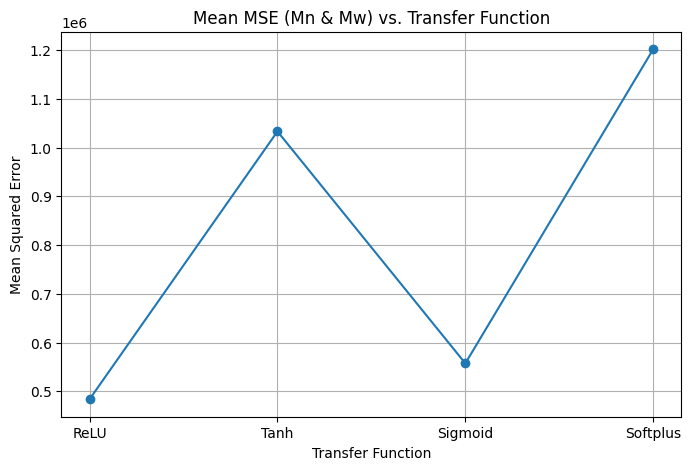

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

transfer_functions = {
    'relu': 'ReLU',
    'tanh': 'Tanh', 
    'sigmoid': 'Sigmoid',
    'softplus': 'Softplus'
}

mse_results = []

for activation, name in transfer_functions.items():
    # Clear session and reset seeds
    tf.keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    model = Sequential()
    model.add(Input(shape=(X_train_z.shape[1],)))  # Use scaled data
    model.add(Dense(16, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='tanh'))
    
    model.compile(optimizer='adam', loss='mse')
    
    # Use scaled data and proper batch size/epochs
    model.fit(X_train_z, y_train_s,             # Scaled data
              validation_data=(X_val_z, y_val_s), # Add validation
              batch_size=16, epochs=200, verbose=0)  # Better parameters
    
    # Predict and convert back to real units
    y_pred_s = model.predict(X_test_z, verbose=0)
    y_pred = inv_y(y_pred_s)  # Convert to real units
    
    mse = mean_squared_error(y_test, y_pred)
    mse_results.append(mse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(transfer_functions.values()), mse_results, marker='o', linestyle='-')
plt.title('Mean MSE (Mn & Mw) vs. Transfer Function')
plt.xlabel('Transfer Function')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()